In [2]:
!pip install --upgrade pip
!pip uninstall protobuf
!pip install --upgrade "protobuf<=3.19.4"
!pip install transformers emoji datasets
!pip install huggingface_hub

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 36.5 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: pip
    Found existing installation: pip 23.1.2
    Uninstalling pip-23.1.2:
      Successfully uninstalled pip-23.1.2
Found existing installation: protobuf 3.20.3
Uninstalling protobuf-3.20.3:
  Would remove:
    /opt/conda/lib/python3.10/site-packages/google/protobuf/*
    /opt/conda/lib/python3.10/site-packages/protobuf-3.20.3.dist-info/*
  Would not remove (might be manually added):
    /opt/conda/lib/python3.10/site-packages/google/protobuf/unknown_fields.py
Proceed (Y/n)? ^C
ERROR: Operation cancelled by user
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 22.5 MB/s eta 0:00:0000:01
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviou

In [4]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from transformers import AutoTokenizer, TFAutoModel, DataCollatorWithPadding, TrainingArguments, Trainer, EarlyStoppingCallback
from transformers import TFAutoModelForSequenceClassification, TFAutoModelForMultipleChoice
from tensorflow.keras.preprocessing.text import Tokenizer as TFTokenizer
import emoji
from datasets import Dataset
import torch
from torch.utils.data import DataLoader

from transformers import BertTokenizer, TFBertModel

In [5]:
import wandb
from kaggle_secrets import UserSecretsClient

user_secrets = UserSecretsClient()

my_secret = user_secrets.get_secret("wandb_api_key") 

wandb.login(key=my_secret)

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

## Load dataset and split train into training and validation

In [6]:
train_df = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")[['text', 'target']]
test_df = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")[['text']]
train_df.head()

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1


## Clean text to remove things like URLs and Emojis

In [8]:
import re

# Taken from https://stackoverflow.com/a/33417311
emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)

# Keep only alphabetic characters
non_alpha_pattern = re.compile('[^a-zA-Z]')

# Replace abbreviations with full text
abbreviations = {
    r'can\'t': 'cannot',
    r'won\'t': 'will not',
    r'wouldn\'t': 'would not',
    r'\'ll': ' will',
    r'n\'t': ' not',
    r'\'re': ' are',
    r'\'s': ' is',
    r'\'d': ' would',
    r'\'t': ' not',
    r'\'ve': ' have',
    r'\'m': ' am',
}

def clean_text(text):
    text = re.sub(r'http\S+', '<URL>', text) # Remove URLs
    
    text = emoji_pattern.sub(r'', text) # Remove emojis' unicodes
    
    text = emoji.demojize(text) # Convert emojis to code ♥ -> :heart:
    
    text = re.sub(r':\S+', '', text) # Remove text after :
    
    # Remove abbreviations
    for abbrev, replace_text in abbreviations.items():
        text = re.sub(abbrev, replace_text, text)
        
    text = ''.join([x for x in text if x.isalpha() or x == ' ']) # remove all non-alpha characters
    
    text = text.strip()

    return text


train_df.text = train_df.text.apply(lambda x: clean_text(x))
test_df.text = test_df.text.apply(lambda x: clean_text(x))

test_df.head(10)

,text
0,Just happened a terrible car crash
1,Heard about earthquake is different cities sta...
2,there is a forest fire at spot pond geese are ...
3,Apocalypse lighting Spokane wildfires
4,Typhoon Soudelor kills in China and Taiwan
5,We are shakingIt is an earthquake
6,They would probably still show more life than ...
7,Hey How are you
8,What a nice hat
9,Fuck off


## Take all text from training and testing datasets, and then tokenize it using TF's Tokenizer to remove all special characters and convert everything to lowercase

In [9]:
all_text = train_df.text.tolist() + test_df.text.tolist()

# Tokenizer
tf_tokenizer = TFTokenizer(oov_token = '<OOV>')
tf_tokenizer.fit_on_texts(all_text)
sequences = tf_tokenizer.texts_to_sequences(all_text)
max_len = max([len(seq) for seq in sequences])
print(f'Found {len(tf_tokenizer.word_index)} unique words and longest sentence has {max_len} words')

Found 21901 unique words and longest sentence has 32 words


## Now replace text in dataset with final cleaned text from Tokenizer

In [10]:
token_to_word = {token: word for (word, token) in tf_tokenizer.word_index.items()}
def sequences_to_texts(sequences):
    words = []
    for token in sequences:
        if len(token) > 0:
            words.append(token_to_word[token[0]])
        else:
            words.append('<OOV>')
            
    return ''.join(words).replace('<OOV>', ' ')

print(all_text[0])
sequences = tf_tokenizer.texts_to_sequences(all_text[0])
rec_text = sequences_to_texts(sequences)
print(rec_text)

Our Deeds are the Reason of this earthquake May ALLAH Forgive us all
our deeds are the reason of this earthquake may allah forgive us all


In [13]:
def replace_text(text):
    sequences = tf_tokenizer.texts_to_sequences(text)
    return sequences_to_texts(sequences)

train_df.text = train_df.text.apply(lambda x: replace_text(x))
test_df.text = test_df.text.apply(lambda x: replace_text(x))

train_df.head()

,text,target
0,our deeds are the reason of this earthquake ma...,1
1,forest fire near la ronge sask canada,1
2,all residents asked to ishelter in place are ...,1
3,people receive wildfires evacuation orders in ...,1
4,just got sent this photo from ruby alaska as s...,1


## Split into X and y

In [16]:
X_train, y_train = train_df[['text']], train_df[['target']]
X_test = test_df[['text']]

X_train.head()

,text
0,our deeds are the reason of this earthquake ma...
1,forest fire near la ronge sask canada
2,all residents asked to ishelter in place are ...
3,people receive wildfires evacuation orders in ...
4,just got sent this photo from ruby alaska as s...


## Load Pre-trained model

In [18]:
MODEL_NAME = 'bert-large-uncased'
bert_model = TFBertModel.from_pretrained(
    MODEL_NAME
)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [19]:
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

## Bert encoder

In [25]:
MAX_LEN = 60

def bert_encode(data, maxlen):
    input_ids = []
    attention_masks = []

    for i, row in data.iterrows():
        encoded = tokenizer.encode_plus(
            row.text,
            add_special_tokens=True,
            max_length = maxlen,
            padding='max_length',
            return_attention_mask=True,
        )

        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return np.array(input_ids),np.array(attention_masks)

In [26]:
train_input_ids,train_attention_masks = bert_encode(X_train, MAX_LEN)
test_input_ids,test_attention_masks = bert_encode(X_test, MAX_LEN)

## Custom model

In [33]:
class CustomModel(tf.keras.models.Model):
    def __init__(self, pretrained_model):
        super().__init__()
        self.pretrained_model = pretrained_model
        
    def build(self):
        input_ids = tf.keras.layers.Input(shape = (MAX_LEN, ), dtype = 'int32')
        attention_masks = tf.keras.layers.Input(shape = (MAX_LEN,), dtype='int32')
        
        output = self.pretrained_model([input_ids, attention_masks])[1]
        #output = tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis = -1))(output)
        #output = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences = True))(output)
        #output = tf.keras.layers.LSTM(64)(output)
        output = tf.keras.layers.Dense(32, activation = 'relu')(output)
        output = tf.keras.layers.Dense(16, activation = 'relu')(output)
        #output = tf.keras.layers.Dropout(0.2)(output)
        output = tf.keras.layers.Dense(1, activation = 'sigmoid')(output)
        
        model = tf.keras.models.Model(inputs = [input_ids, attention_masks], outputs = output)
        return model

## Load pre-trained model

In [34]:
model_builder = CustomModel(bert_model)
model = model_builder.build()
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 60)]         0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 60)]         0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  335141888   ['input_3[0][0]',                
                                thPoolingAndCrossAt               'input_4[0][0]']                
                                tentions(last_hidde                                               
                                n_state=(None, 60,                                          

## TF model callbacks

In [30]:
def scheduler(epoch, lr):
    return lr * 0.5

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)
early_stopping_loss = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5, restore_best_weights = True)
early_stopping_val_loss = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights = True)

model_callbacks = [lr_scheduler]

## Compile and fit

In [35]:
model.compile(tf.keras.optimizers.SGD(learning_rate = 0.003), loss = 'binary_crossentropy', metrics = ['accuracy'])

history = model.fit(
    [train_input_ids, train_attention_masks], y_train.to_numpy(),
    validation_split = 0.2,
    epochs=10,
    batch_size = 8,
    callbacks = model_callbacks
)

Epoch 1/10
762/762 [==============================] - 274s 285ms/step - loss: 0.5575 - accuracy: 0.7315 - val_loss: 0.7162 - val_accuracy: 0.6034 - lr: 0.0015
Epoch 2/10
762/762 [==============================] - 211s 277ms/step - loss: 0.4351 - accuracy: 0.8163 - val_loss: 0.4154 - val_accuracy: 0.8207 - lr: 7.5000e-04
Epoch 3/10
762/762 [==============================] - 211s 277ms/step - loss: 0.3883 - accuracy: 0.8429 - val_loss: 0.4202 - val_accuracy: 0.8267 - lr: 3.7500e-04
Epoch 4/10
762/762 [==============================] - 210s 276ms/step - loss: 0.3764 - accuracy: 0.8483 - val_loss: 0.3968 - val_accuracy: 0.8437 - lr: 1.8750e-04
Epoch 5/10
762/762 [==============================] - 211s 277ms/step - loss: 0.3640 - accuracy: 0.8545 - val_loss: 0.4028 - val_accuracy: 0.8345 - lr: 9.3750e-05
Epoch 6/10
762/762 [==============================] - 211s 277ms/step - loss: 0.3578 - accuracy: 0.8567 - val_loss: 0.4011 - val_accuracy: 0.8372 - lr: 4.6875e-05
Epoch 7/10
762/762 [======

## Plot metrics

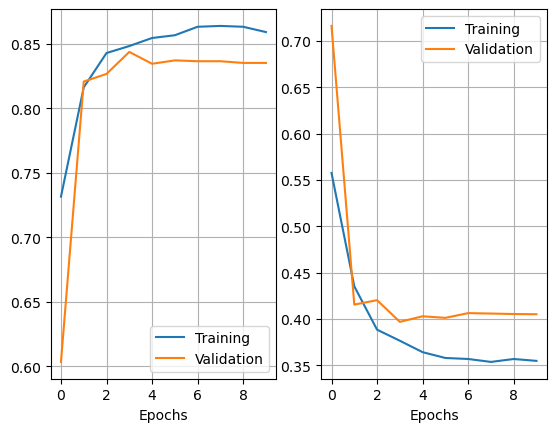

In [38]:
fig, axes = plt.subplots(nrows = 1, ncols = 2)

axes[0].plot(history.history['accuracy'], label = 'Training')
axes[0].plot(history.history['val_accuracy'], label = 'Validation')
axes[0].legend()
axes[0].grid(True)
axes[0].set_xlabel('Epochs')

axes[1].plot(history.history['loss'], label = 'Training')
axes[1].plot(history.history['val_loss'], label = 'Validation')
axes[1].legend()
axes[1].grid(True)
axes[1].set_xlabel('Epochs')

plt.show()

## Predict

In [45]:
preds = model.predict([test_input_ids, test_attention_masks])
preds = np.where(preds > 0.5, 1, 0)

102/102 [==============================] - 30s 290ms/step


## Prepare submission

In [46]:
preds = np.where(preds > 0.5, 1, 0)
submission = pd.read_csv('/kaggle/input/nlp-getting-started/sample_submission.csv')
submission.target = preds.astype('int32')

submission.to_csv('submission.csv', index = False)

## Save model

In [52]:
model.save(MODEL_NAME.replace('/', '-') + '-disaster-tweets')

In [47]:
from huggingface_hub import notebook_login
notebook_login()

model.push_to_hub(MODEL_NAME.replace('/', '-') + '-disaster-tweets')

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:4                                                                                    │
│                                                                                                  │
│   1 from huggingface_hub import notebook_login                                                   │
│   2 notebook_login()                                                                             │
│   3                                                                                              │
│ ❱ 4 model.push_to_hub(MODEL_NAME.replace('/', '-') + '-disaster-tweets')                         │
│   5                                                                                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
AttributeError: 'Functional' object has no attribute 'push_to_hub'